In [135]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

import torchio as tio
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

from sklearn.ensemble import VotingClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

from seaborn import heatmap


from functions import *

In [136]:
metaData = pd.read_csv('../metaDataTrain.csv')
metaDataClean = metaData.iloc
subject_list = load_training_dataset(metaDataClean)

## Let us construct the features vectors

In [137]:
features = np.zeros((100, 20))

Let us add volume information to feature vectors

In [138]:
volumes_1_ed = []
volumes_2_ed = []
volumes_3_ed = []

volumes_1_es = []
volumes_2_es = []
volumes_3_es = []
   
for i in range(0, 100):
    subject = subject_list[i]
    
    ed_view = subject.ed_seg
    sum_volumes = get_volume(ed_view, 0) + get_volume(ed_view, 1) + get_volume(ed_view, 2) + get_volume(ed_view, 3)
    volumes_1_ed.append(get_volume(ed_view, 1)/sum_volumes)
    volumes_2_ed.append(get_volume(ed_view, 2)/sum_volumes)
    volumes_3_ed.append(get_volume(ed_view, 3)/sum_volumes)

    es_view = subject.es_seg
    sum_volumes = get_volume(es_view, 0) + get_volume(es_view, 1) + get_volume(es_view, 2) + get_volume(es_view, 3)
    volumes_1_es.append(get_volume(es_view, 1)/sum_volumes)
    volumes_2_es.append(get_volume(es_view, 2)/sum_volumes)
    volumes_3_es.append(get_volume(es_view, 3)/sum_volumes)

volumes_1_ed = np.array([volumes_1_ed]).flatten() 
volumes_2_ed = np.array([volumes_2_ed]).flatten() 
volumes_3_ed = np.array([volumes_3_ed]).flatten() 

volumes_1_es = np.array([volumes_1_es]).flatten() 
volumes_2_es = np.array([volumes_2_es]).flatten() 
volumes_3_es = np.array([volumes_3_es]).flatten() 

######### new features
ejection_fraction_right = (volumes_1_ed - volumes_1_es) / volumes_1_ed
ejection_fraction_left = (volumes_3_ed - volumes_3_es) / volumes_3_ed


ratioRL_ed = volumes_3_ed / volumes_1_ed
ratioRL_es = volumes_3_es / volumes_1_es

ratioML_ed = volumes_2_ed / volumes_1_ed
ratioML_es = volumes_2_es / volumes_1_es


for i, new_col in enumerate([ratioRL_ed[:], ratioRL_es[:], ratioML_ed[:], ratioML_es[:], ejection_fraction_right[:], volumes_1_ed[:], volumes_2_ed[:], volumes_3_ed[:], ejection_fraction_left[:], volumes_1_es[:], volumes_2_es[:], volumes_3_es[:]]):
    features[:,i] = new_col

Now add myocardium thickness information

In [139]:
ed_thickness = np.array(metaData.iloc[:, 8:])
features[:,-8:] = ed_thickness

Let us just give our explicit class vector

In [140]:
classes = np.zeros((100))
classes[:20] = 2
classes[20:40] = 3
classes[40:60] = 1
classes[60:80] = 0
classes[80:100] = 4
classes = classes.astype('int')

## Time to tree out this stuff!

First split and transform data

In [141]:
mask = np.ones(features.shape[1], dtype = bool)
mask[[-1,-2,-3,-4,-5,-6,-7,-8]] = False
features = features[:, mask]

In [142]:
features, classes = shuffle(features, classes)
X_train, X_val, y_train, y_val = train_test_split(features, classes, test_size=0.25, stratify=classes, random_state=32)

Look for optimal parameters

In [143]:
clf = RandomForestClassifier(n_estimators=1000)
#clf.fit(features, classes)
clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1000)

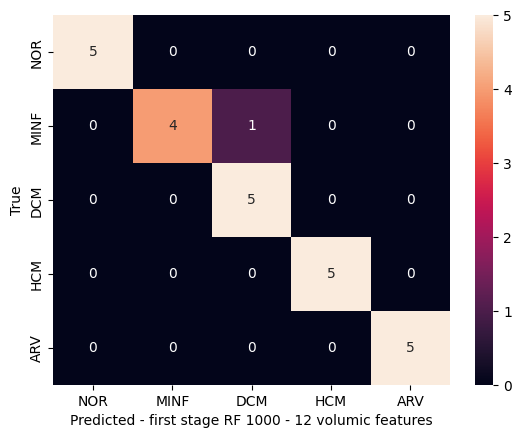

In [144]:
val_preds = clf.predict(X_val)
cm = confusion_matrix(y_val, val_preds, labels=[0,1,2,3,4])
heatmap(cm, annot=True, fmt='d', xticklabels=['NOR','MINF','DCM','HCM','ARV'], yticklabels=['NOR','MINF','DCM','HCM','ARV'])
plt.xlabel('Predicted - first stage RF 1000 - 12 volumic features')
plt.ylabel('True')
plt.show()

In [145]:
subject_to_expert_train = np.concatenate((np.where(y_train == 1), np.where(y_train == 2)), axis = 1)[0]
features_expert_train = X_train[subject_to_expert_train]
classes_expert_train = y_train[subject_to_expert_train]

scaler = StandardScaler()
scaler.fit(features_expert_train)
features_expert_train_scaled = scaler.transform(features_expert_train)

features_expert_train, features_expert_train_scaled, classes_expert_train = shuffle(features_expert_train, features_expert_train_scaled, classes_expert_train)

In [146]:
xgb_expert = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)

xgb_expert.fit(features_expert_train_scaled, classes_expert_train)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)

In [147]:
subject_to_expert_val = np.concatenate((np.where(y_val == 1), np.where(y_val == 2)), axis = 1)[0]
features_expert_val = X_val[subject_to_expert_val]
classes_expert_val = y_val[subject_to_expert_val]

features_expert_val_scaled = scaler.transform(features_expert_val)

val_preds_expert = xgb_expert.predict(features_expert_val_scaled)

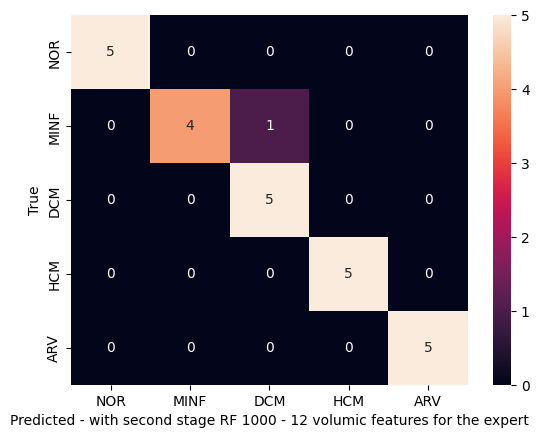

In [148]:
final_val_preds = val_preds.copy()
final_val_preds[subject_to_expert_val] = val_preds_expert

cm = confusion_matrix(y_val, final_val_preds, labels=[0,1,2,3,4])
heatmap(cm, annot=True, fmt='d', xticklabels=['NOR','MINF','DCM','HCM','ARV'], yticklabels=['NOR','MINF','DCM','HCM','ARV'])
plt.xlabel('Predicted - with second stage RF 1000 - 12 volumic features for the expert')
plt.ylabel('True')
plt.show()

## Now let us test that model on the test dataset

In [29]:
metaDataTest = pd.read_csv('../metaDataTest.csv')

test_features = np.zeros((50, 20))  

In [30]:
test_subject_list1 = load_filled_test_dataset()
test_subject_list = load_test_dataset()

volumes_1_ed = []
volumes_2_ed = []
volumes_3_ed = []

volumes_1_es = []
volumes_2_es = []
volumes_3_es = []
   
for i in range(0, 50):
    subject1 = test_subject_list1[i]

    subject_ed = test_subject_list[i].ed_seg.data.numpy()[0]
    ed_view = subject1.ed_seg

    sum_volumes = get_volume(ed_view, 0) + get_volume(ed_view, 1) + get_volume(ed_view, 2) + int((lv_volume(subject_ed == 2)).sum())
    volumes_1_ed.append(get_volume(ed_view, 1)/sum_volumes)
    volumes_2_ed.append(get_volume(ed_view, 2)/sum_volumes)
    volumes_3_ed.append(int((lv_volume(subject_ed == 2)).sum())/sum_volumes)

    subject_es = test_subject_list[i].es_seg.data.numpy()[0]
    es_view = subject1.es_seg

    sum_volumes = get_volume(es_view, 0) + get_volume(es_view, 1) + get_volume(es_view, 2) + int((lv_volume(subject_es == 2)).sum())
    volumes_1_es.append(get_volume(es_view, 1)/sum_volumes)
    volumes_2_es.append(get_volume(es_view, 2)/sum_volumes)
    volumes_3_es.append(int((lv_volume(subject_es == 2)).sum())/sum_volumes)

volumes_1_ed = np.array([volumes_1_ed]).flatten()
volumes_2_ed = np.array([volumes_2_ed]).flatten()
volumes_3_ed = np.array([volumes_3_ed]).flatten()

volumes_1_es = np.array([volumes_1_es]).flatten()
volumes_2_es = np.array([volumes_2_es]).flatten()
volumes_3_es = np.array([volumes_3_es]).flatten()


ejection_fraction_right = (volumes_1_ed - volumes_1_es) / volumes_1_ed
ejection_fraction_left = (volumes_3_ed - volumes_3_es) / volumes_3_ed


ratioRL_ed = volumes_3_ed / volumes_1_ed
ratioRL_es = volumes_3_es / volumes_1_es

ratioML_ed = volumes_2_ed / volumes_1_ed
ratioML_es = volumes_2_es / volumes_1_es


for i, new_col in enumerate([ratioRL_ed[:], ratioRL_es[:], ratioML_ed[:], ratioML_es[:], ejection_fraction_right[:], volumes_1_ed[:], volumes_2_ed[:], volumes_3_ed[:], ejection_fraction_left[:], volumes_1_es[:], volumes_2_es[:], volumes_3_es[:]]):
    test_features[:,i] = new_col

In [31]:
ed_myo_thickness_test = np.array(metaDataTest.iloc[:, 7:])

test_features[:,-8:] = ed_myo_thickness_test

test_features = test_features[:, mask]

We can now predict

In [32]:
test_preds = clf.predict(test_features)

In [33]:
subject_to_expert = np.concatenate((np.where(test_preds == 1), np.where(test_preds == 2)), axis = 1)[0]
features_expert = test_features[subject_to_expert]
classes_expert = test_preds[subject_to_expert]

featus_expert_scaled = scaler.transform(features_expert)

expert_preds = xgb_expert.predict(featus_expert_scaled)

In [34]:
final_preds = test_preds.copy()
final_preds[subject_to_expert] = expert_preds

And write down for submission

In [35]:
df = pd.read_csv("../SampleSubmission.csv")
df.iloc[:, 1] = final_preds
df.to_csv("../SampleSubmission.csv", index=False)